# Predicting Hospital Readmission

Alexander Lindsey

43438150

December 21, 2020

[Github](https://github.com/alexanderblindsey/hospital_readmissions)

## Background

In this investigation, I use the data collected in [Strack et. al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/) to predict the readmission of patients admitted to a hospital or integrated delivery network in the United States from 1999-2008. The data contains 101,766 hospital visits for 71,518 unique patients. The dataset contains patient information, such as their race, gender, and age, alongside variables relating to the nature of their admission to the hospital, such as their diagnoses, time in hospital, test results, etc.

## Cost of Readmission

A readmission occurs when a patient has been readmitted to the hospital within 30 days of an earlier hospital stay. The economic cost of hospital readmissions is considerably large - readmission of elderly patients costs the federal health insurer, Medicare, approximately [$15 billion dollars per year](https://www.healthstream.com/resources/blog/blog/2020/06/02/the-economic-emotional-cost-of-hospital-readmissions#:~:text=The%20cost%20of%20hospital%20readmissions,the%20program%20received%20readmissions%20penalties.).

The Center for Medicare & Medicaid Services (CMS) penalizes hospitals for patient readmission, reducing hospital revenue. Additionally, patients and their families suffer an emotional, physical, and financial toll when they are readmitted. 

Models similair to the one(s) created in this investigation could be used by hospitals and medical insurers to predict hospital readmission, driving down costs. 

## Goal

The goal of this investigation is to create a classification model using supervised machine learning that predicts if a patient will be readmitted or not. Models are optimized for  accuracy, where 
$$accuracy= \frac{positive\ observations}{total\ observations}\tag{1}$$


## Raw Dataset Description

One concern with this dataset is that there are _a lot_ of categorical features - one-hot encoding the dataset with minimal feature engineering results in over 2,500 columns. While this may also impact model accuracy, training models with so many columns and tens of thousands of observations is very computationally intensive and therefore impractical. As a result, I'm liberal with dropping columns and further-categorizing categorical variables.

Below is a list of features and their descriptions. 
- `encounter_id`: Unique identifier of an encounter.
- `patient_nbr`: Unique identifier of a patient.
- `race`: Caucasian, Asian, African American, Hispanic, and other.
- `gender`: male, female, and unknown/invalid.
- `age`: Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100).
- `weight`: Weight in pounds.
- `admission_type_id`: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available.
- `discharge_disposition_id`: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.
- `admission source_id`: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital.
- `time_in_hospital`: Integer number of days between admission and discharge.
- `payer_code`: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay.
- `medical_specialty`: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon.
- `num_lab_procedures`: Number of lab tests performed during the encounter.
- `numb_procedures`: Number of procedures (other than lab tests) performed during the encounter.
- `num_medications`: Number of distinct generic names administered during the encounter.
- `number_outpatient`: Number of outpatient visits of the patient in the year preceding the encounter.
- `number_emergency`: Number of emergency visits of the patient in the year preceding the encounter.
- `number_inpatient`: Number of inpatient visits of the patient in the year preceding the encounter.
- `diag_1`: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values.
- `diag_2`: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values.
- `diag_3`: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values.
- `number_diagnoses`: Number of diagnoses entered to the system
- `max_glu_serum`: Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured.
- `A1Cresult`: Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- `change`: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”.
- `diabetesMed`: Indicates if there was any diabetic medication prescribed. Values: "yes" and "no".
- 24 features for medications: Medications under their generic names: `metformin`, `repaglinide`, `nateglinide`, `chlorpropamide`, `glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`, `rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `sitagliptin`, `insulin`, `glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, and `metformin- pioglitazone`. The feature indicates whether the drug was prescribed or there was a change in the dosage. _Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed._
- `readmitted`: Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

## Imports & Reading in Data

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.ensemble import (VotingClassifier,
                              AdaBoostClassifier,
                              RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import (LogisticRegression,
                                  SGDClassifier)
from sklearn.metrics import (accuracy_score,
                             f1_score, 
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             classification_report,
                             roc_curve)

%matplotlib inline

In [2]:
# read data
df = pd.read_csv('Data/Raw/diabetic_data.csv')
codes = pd.read_csv('Data/Raw/IDs_mapping.csv')

## Data

First, I clean `IDs_mapping.csv`, which contains descriptions for values in the primary dataset, and convert it to a dataframe.  

### codes

In [3]:
# clean ids_mapping.csv, imported as codes
codes = codes[(codes['description']!='description')] 

# merge
codes = pd.merge(codes.copy()[40:].rename(columns={'description':'admission_source_id',
                                                     'admission_type_id':'values'}),
                 (pd.merge(codes.copy()[0:8].rename(columns={'description':'admission_type_id',
                                                             'admission_type_id':'values'}),
                           codes.copy()[9:39].rename(columns={'description':'discharge_disposition_id',
                                                              'admission_type_id':'values'}),
                           how='outer',
                           left_on='values',
                           right_on='values')),
                 how='outer',
                 left_on='values',
                 right_on='values').reset_index(drop=True)

# some NAN should actually be NULL
codes.loc[15, 'admission_source_id'] = 'NULL'
codes.loc[5, 'admission_type_id'] = 'NULL'
codes.loc[16, 'discharge_disposition_id'] = 'NULL'
codes.head(10)

,values,admission_source_id,admission_type_id,discharge_disposition_id
0,1,Physician Referral,Emergency,Discharged to home
1,2,Clinic Referral,Urgent,Discharged/transferred to another short term h...
2,3,HMO Referral,Elective,Discharged/transferred to SNF
3,4,Transfer from a hospital,Newborn,Discharged/transferred to ICF
4,5,Transfer from a Skilled Nursing Facility (SNF),Not Available,Discharged/transferred to another type of inpa...
5,6,Transfer from another health care facility,NULL,Discharged/transferred to home with home healt...
6,7,Emergency Room,Trauma Center,Left AMA
7,8,Court/Law Enforcement,Not Mapped,Discharged/transferred to home under care of H...
8,9,Not Available,NaN,Admitted as an inpatient to this hospital
9,10,Transfer from critial access hospital,NaN,Neonate discharged to another hospital for neo...


### Hospital Readmissions

I make some minor changes to the dataset used to predict readmission, `df`. 

The raw dataset contains three possible values for readmission:
- `NO`
    - If the patient was never readmitted.
- `>30`
    - If the patient was readmitted after 30 days.
- `<30`
    - If the patient was readmitted before 30 days.
    
Because we only care about readmission before 30 days, all observations with `>30` is replaced with `NO`, making the `readmissions` feature binary.


In [4]:
df.replace('?', np.nan, inplace=True) # NaN represented as ? in raw file

df.drop(['encounter_id'], axis=1, inplace=True) # encounter_id is redundant - each encounter_id and index are unique

df['readmitted'].replace({'<30':'YES', '>30':'NO'}, inplace=True) # make readmitted binary
df.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
1,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
2,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Initial Investigation

Below are general information regarding the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  numb

Below are the number of unique values for each feature.

In [6]:
print(f'Total Values = {len(df)}\n\nUnique Values:')
for c in df.columns:
    print(f'{c}: {df[c].nunique()}')

Total Values = 101766

Unique Values:
patient_nbr: 71518
race: 5
gender: 3
age: 10
weight: 9
admission_type_id: 8
discharge_disposition_id: 26
admission_source_id: 17
time_in_hospital: 14
payer_code: 17
medical_specialty: 72
num_lab_procedures: 118
num_procedures: 7
num_medications: 75
number_outpatient: 39
number_emergency: 33
number_inpatient: 21
diag_1: 716
diag_2: 748
diag_3: 789
number_diagnoses: 16
max_glu_serum: 4
A1Cresult: 4
metformin: 4
repaglinide: 4
nateglinide: 4
chlorpropamide: 4
glimepiride: 4
acetohexamide: 2
glipizide: 4
glyburide: 4
tolbutamide: 2
pioglitazone: 4
rosiglitazone: 4
acarbose: 4
miglitol: 4
troglitazone: 2
tolazamide: 3
examide: 1
citoglipton: 1
insulin: 4
glyburide-metformin: 4
glipizide-metformin: 2
glimepiride-pioglitazone: 2
metformin-rosiglitazone: 2
metformin-pioglitazone: 2
change: 2
diabetesMed: 2
readmitted: 2


Below are summary statics for continuous variables in `df`.

In [7]:
pd.options.display.float_format = "{:.2f}".format # two decimal places
df.drop(['patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'],
        axis=1).describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00,101766.00
mean,4.40,43.10,1.34,16.02,0.37,0.20,0.64,7.42
std,2.99,19.67,1.71,8.13,1.27,0.93,1.26,1.93
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00
25%,2.00,31.00,0.00,10.00,0.00,0.00,0.00,6.00
50%,4.00,44.00,1.00,15.00,0.00,0.00,0.00,8.00
75%,6.00,57.00,2.00,20.00,0.00,0.00,1.00,9.00
max,14.00,132.00,6.00,81.00,42.00,76.00,21.00,16.00


## Unique Patients

The dataset contains 101,766 observations for 71,518 patients, meaning some patients appear in the dataset several times. Intuitively, for each of these reapeat patients, every observation except for the observation with the maximum index value (i.e., the last observation for that patient in the dataframe) is readmitted. 

Because every patient with multiple observations must have been readmitted, and because having multiple of the same patient may introduce bias towards those with multiple observations, all but the first  observation is dropped for each non-unique patient.

As a result, the dataframe drops to 71,518 observations, each being a unique patient.

In [8]:
df.drop_duplicates(subset= ['patient_nbr'], keep = 'first', inplace=True)
df.drop(['patient_nbr'], axis=1, inplace=True) # patient_nbr becomes redundant

In [9]:
df.shape

(71518, 48)

## Missing Values

Figure 1 contains the number of missing values for each feature containing missing values. As can be seen, `weight`, `payer_code` and `medical_specialty` many missing values.

Over 90% of `weight` is missing, so it is dropped from the dataset. `payer_code`, `medical_specialty` are both dropped as nearly 50% are missing. 

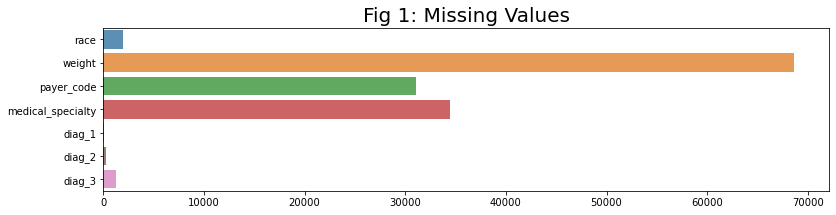

In [10]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.barplot(x=df.isnull().sum()[df.isnull().sum()>0],
            y=df.columns[df.isna().any()].tolist(),
            orient='h',
            alpha=0.8)

plt.title('Fig 1: Missing Values', size=20);

### Impute Missing Values

The missing values for primary diagnosis (`diag_1`) and `race` are imputed with the most commonly occuring value of that feature.

`diag_1` is renamed to `diagnosis`. 

In [11]:
df.rename(columns={'diag_1':'diagnosis'}, inplace=True)

In [12]:
max_race = df['race'].value_counts().idxmax()
max_diag = df['diagnosis'].value_counts().idxmax()

for i in tqdm(df.index):
    current_race = df.at[i, 'race']
    current_diag = df.at[i, 'diagnosis']
    
    if pd.isnull(current_race) == True:
        df.at[i, 'race'] = max_race

    if pd.isnull(current_diag) == True:
        df.at[i, 'diagnosis'] = max_diag

100%|██████████| 71518/71518 [00:00<00:00, 118692.64it/s]


### Drop Features

Several features are removed from the analysis at this stage. 

`diag_2` and `diag_3` are dropped as `diag_1` is already included and they are categorical variables with many unique values, drastically increasing the size of the one-hot encoded dataframe. 

Various drug features are dropped as well. This is because these features have no variation, making them redundant.

In [13]:
# features with no observation
for c in df.columns:
    if df[c].value_counts().nunique()<2:
        print(c)

examide
citoglipton
glimepiride-pioglitazone


In [14]:
cols_to_drop = ['weight',
                'payer_code',
                'medical_specialty',
                'diag_2',
                'diag_3',
                'examide',
                'glimepiride-pioglitazone',
                'citoglipton']

df.drop(cols_to_drop, axis=1, inplace=True)

## Categorization of Diagnoses

There are hundreds of different diagnoses in `df`.

In an effort to better categorize these features, I bin each observation, depending on the ICD9 code listed in the `diagnosis` feature, into one of 18 different categories listed [here](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). 

In [15]:
for i in df.index:
    d = df.at[i, 'diagnosis']
    
    try:
        d = float(df.at[i, 'diagnosis'])
        
    except ValueError:
        df.at[i, 'diagnosis'] = 'other'
    
    else:
        if d>=1 and d<=139:
            df.at[i, 'diagnosis'] = 'infections/parasitic'
        elif d>=140 and d<=239:
            df.at[i, 'diagnosis'] = 'neoplasms'
        elif d>=240 and d<=279:
            df.at[i, 'diagnosis'] = 'endocrine/nutrition/immunity'
        elif d>= 280 and d<=289:
            df.at[i, 'diagnosis'] = 'blood'
        elif d>=290 and d<=319:
            df.at[i, 'diagnosis'] = 'mental disorders'
        elif d>=320 and d<=329:
            df.at[i, 'diagnosis'] = 'nervous system'
        elif d>=390 and d<=459:
            df.at[i, 'diagnosis'] = 'circulatory'
        elif d>=460 and d<=519:
            df.at[i, 'diagnosis'] = 'respiratory'
        elif d>=520 and d<=579:
            df.at[i, 'diagnosis'] = 'digestive'
        elif d>=580 and d<=629:
            df.at[i, 'diagnosis'] = 'genitourinary'
        elif d>=630 and d<=679:
            df.at[i, 'diagnosis'] = 'pregnancy/childbirth'
        elif d>=680 and d<=709:
            df.at[i, 'diagnosis'] = 'skin/subcutaneous tissue'
        elif d>=710 and d<=739:
            df.at[i, 'diagnosis'] = 'musculoskeletal'
        elif d>=740 and d<=759:
            df.at[i, 'diagnosis'] = 'congenital anomalies'
        elif d>=760 and d<=779:
            df.at[i, 'diagnosis'] = 'perinatal'
        elif d>=780 and d<=799:
            df.at[i, 'diagnosis'] = 'ill-defined'
        else:
            df.at[i, 'diagnosis'] = 'injury/poisoning'

## Gender

Gender has an `Unknown/Invalid` outcome with 3 observations. This creates an extra column that can cause issues if all observations end up in either `X_train` or `y_train`, and so these are randomly assigned `male` or `female`.

In [16]:
x = random.randint(2)

for i in df.index:
    current_gender = df.at[i, 'gender']
    
    if current_gender == 'Unknown/Invalid':
        if x == 0:
            df.at[i, 'gender'] = 'Male'
        else:
            df.at[i, 'gender'] = 'Female'

## Test Features

`max_glu_serum` and `A1C` result are categorical features indicating the test result(s) of each patient. I reduce the categories in an effort to cut down on attributes in the final one-hot encoded dataframe while retaining most of the attribute's predictive power.

In [17]:
for i in df.index:
    current_a1c = df.at[i, 'A1Cresult']
    current_glu = df.at[i, 'max_glu_serum']
    
    if current_a1c in ['>8', '>7']:
        df.at[i, 'A1Cresult'] = 'high'
    
    if current_glu in ['>200', '>300']:
        df.at[i, 'max_glu_serum'] = 'high'

# Exploratory Analysis

## Readmission

As can be seen below, the prevalance of readmission in this dataset is very low - likely a reflection of the fact that readmission is costly to care providers.

Because of this low prevalance rate, accuracy is a poor optimization metric if used alone. In this case, a classifier that only predicted a patient would not be readmitted would still be over 90% accurate.

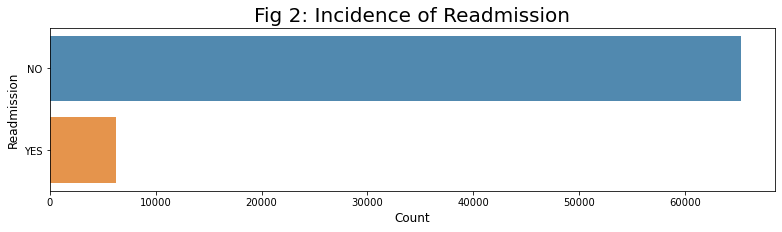

In [18]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.countplot(y='readmitted', data=df, alpha=0.85)
plt.title('Fig 2: Incidence of Readmission', size=20)
plt.xlabel('Count', size=12)
plt.ylabel('Readmission', size=12);

## Incidence of Features (Non-Drug) vs. Readmission

In Figure 4, below, shows the incidence of each non-drug feature, broken down by readmission. 

Unfortunantly, readmission is very low for each feature - no feature stands out that might play a major role in predicting readmission. However, there are a few patterns to note:
- The likelyhood of readmission increases as time in hospital increases.
- The likelyhood of readmission increases with age.
- The likelyhood of readmission increases was the number of medications increases, until the likelyhood starts to decrease. 
- The likelyhood of readmission increases with the number of diagnoses, spiking at 9 diagnoses. 
- The likelyhood of readmission increases with time in hospital. 

Note that the y-axis is the number of observations. 

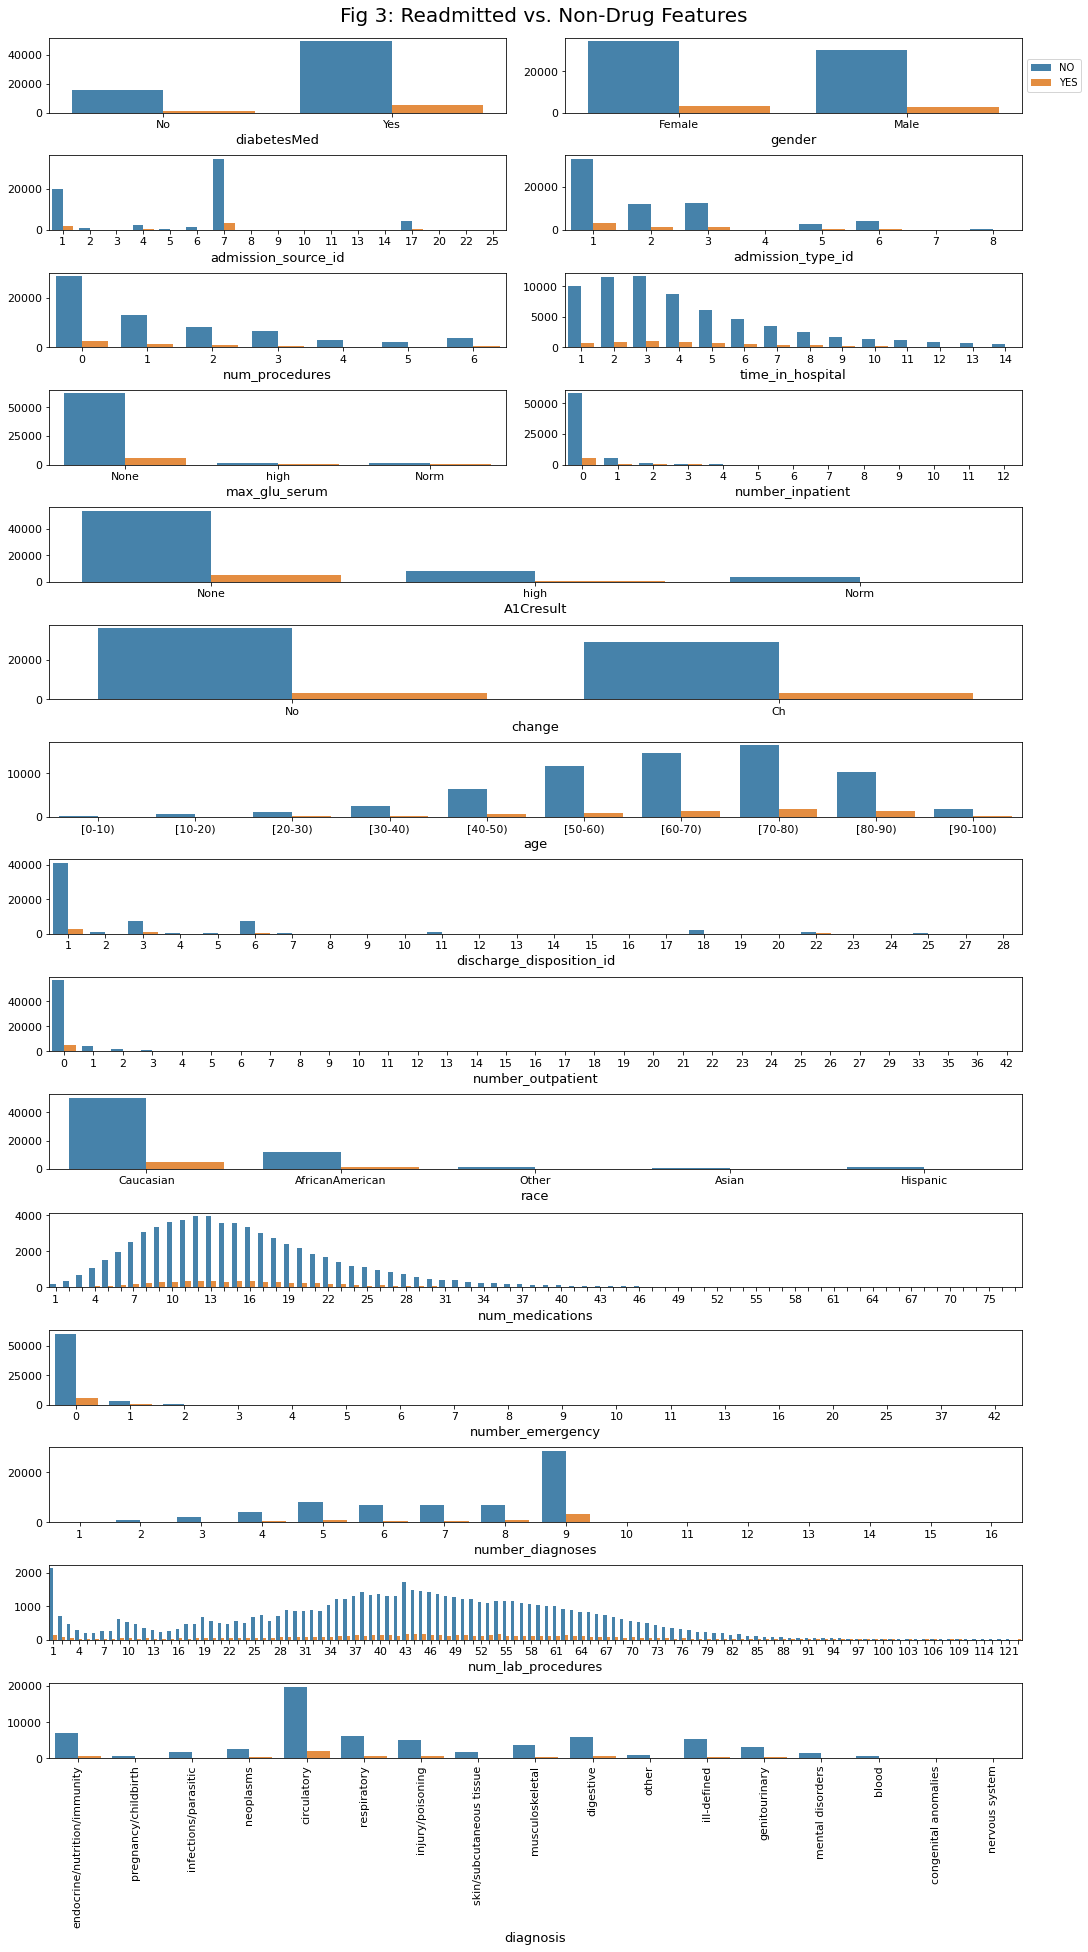

In [19]:
columns = ['gender',
           'diabetesMed',
           'admission_type_id',
           'admission_source_id',
           'time_in_hospital',
           'num_procedures',
           'number_inpatient',
           'max_glu_serum',
           'A1Cresult',
           'change',
           'age',
           'discharge_disposition_id',
           'number_outpatient',
           'race',           
           'num_medications',
           'number_emergency',
           'number_diagnoses',
           'num_lab_procedures',
           'diagnosis']

def print_countplots(fig, columns, hue=df['readmitted'], tight=[], df=df, col_pos=0):
    for i, ax in enumerate(fig.axes):
        sns.countplot(x=df[columns[col_pos]], hue=hue, ax=ax, alpha=0.9)
        ax.get_legend().remove()
        ax.set_ylabel('')
        ax.set_xlabel(df[columns[col_pos]].name, size=13)
        ax.tick_params(axis='both', which='major', labelsize=11)

        if df[columns[col_pos]].name == 'diagnosis':
            _ = plt.xticks(rotation=90)
            
        if df[columns[col_pos]].name in tight:
            n=3
            [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
            
        if ax == ax0:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        col_pos += 1

fig = plt.figure(constrained_layout=True, figsize=(15, 27))
gs = GridSpec(15, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 1:])
ax0_ = fig.add_subplot(gs[0, :1])
ax1 = fig.add_subplot(gs[1, 1:])
ax1_ = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[2, 1:])
ax2_ = fig.add_subplot(gs[2, :1])
ax3 = fig.add_subplot(gs[3, 1:])
ax3_ = fig.add_subplot(gs[3, :1])
ax4 = fig.add_subplot(gs[4, :])
ax5 = fig.add_subplot(gs[5, :])
ax6 = fig.add_subplot(gs[6, :])
ax7 = fig.add_subplot(gs[7, :])
ax8 = fig.add_subplot(gs[8, :])
ax9 = fig.add_subplot(gs[9, :])
ax10 = fig.add_subplot(gs[10, :])
ax11 = fig.add_subplot(gs[11, :])
ax12 = fig.add_subplot(gs[12, :])
ax13 = fig.add_subplot(gs[13, :])
ax14 = fig.add_subplot(gs[14, :])


print_countplots(fig=fig, columns=columns, tight=['num_medications',
                                                  'num_lab_procedures'])
fig.suptitle("Fig 3: Readmitted vs. Non-Drug Features", size=20);

## Drug Features vs. Readmissions

Figure 4 below shows the same as Figure 3 but for drug features. Unfortnately, no features stand out in its possible ability to explain the variance of readmission.

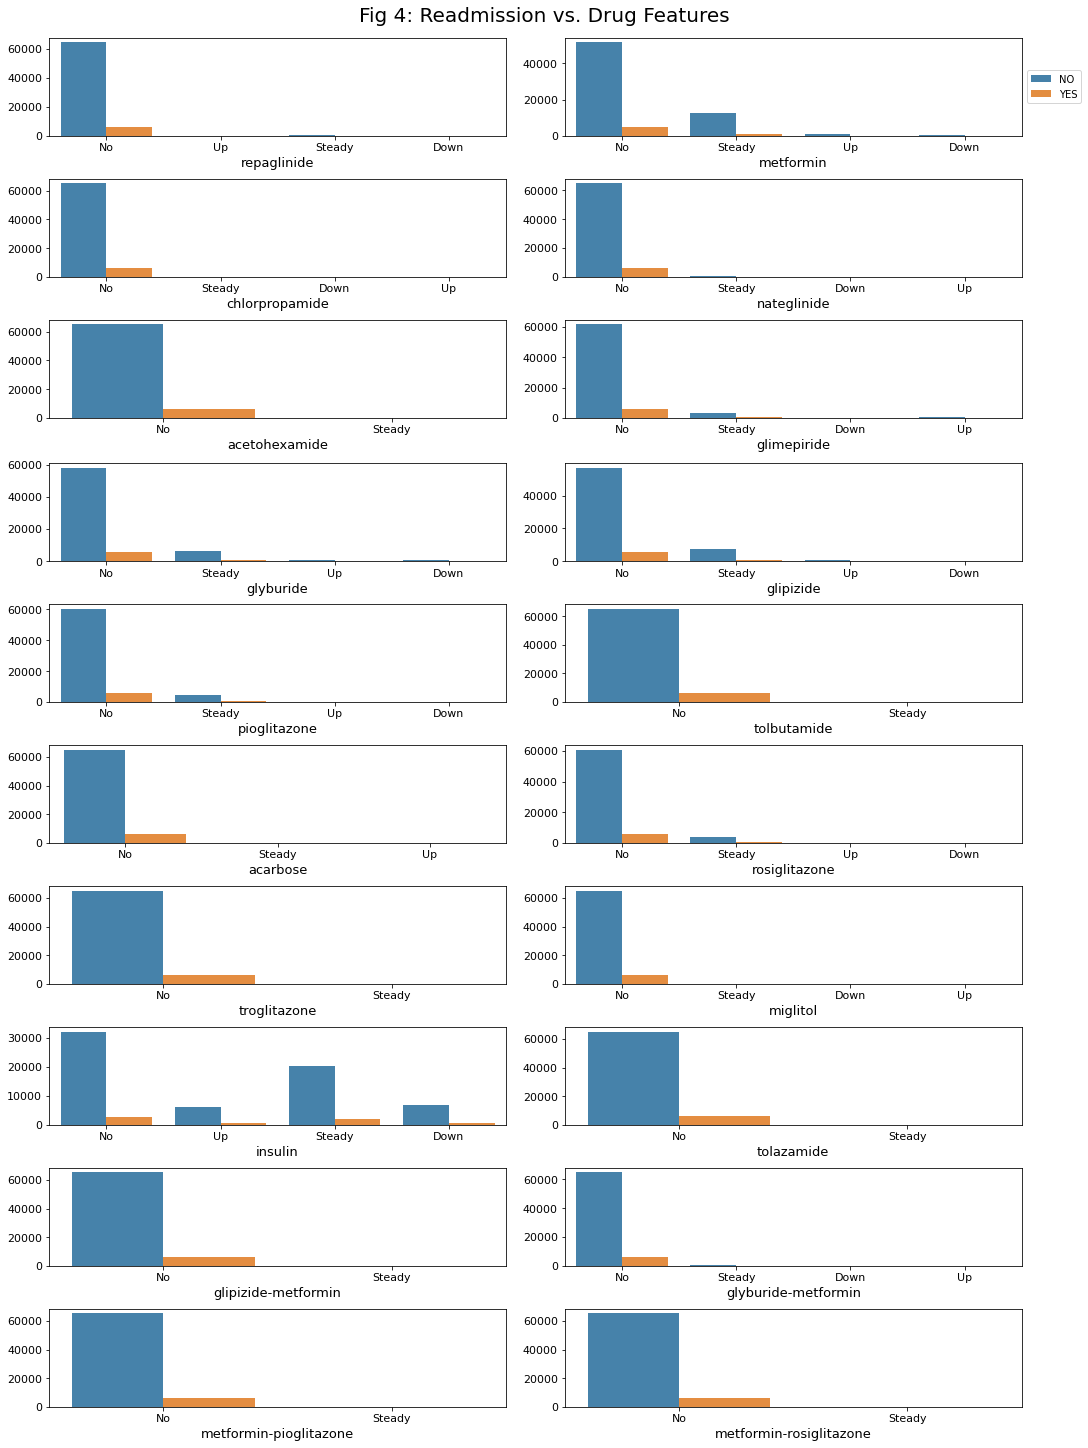

In [20]:
drug_cols = [col for col in df.columns.drop(['readmitted']) if col not in columns]

fig = plt.figure(constrained_layout=True, figsize=(15, 20))
gs = GridSpec(10, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, 1:])
ax0_ = fig.add_subplot(gs[0, :1])
ax1 = fig.add_subplot(gs[1, 1:])
ax1_ = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[2, 1:])
ax2_ = fig.add_subplot(gs[2, :1])
ax3 = fig.add_subplot(gs[3, 1:])
ax3_ = fig.add_subplot(gs[3, :1])
ax4 = fig.add_subplot(gs[4, 1:])
ax4_ = fig.add_subplot(gs[4, :1])
ax5 = fig.add_subplot(gs[5, 1:])
ax5_ = fig.add_subplot(gs[5, :1])
ax6 = fig.add_subplot(gs[6, 1:])
ax6_ = fig.add_subplot(gs[6, :1])
ax7 = fig.add_subplot(gs[7, 1:])
ax7_ = fig.add_subplot(gs[7, :1])
ax8 = fig.add_subplot(gs[8, 1:])
ax8_ = fig.add_subplot(gs[8, :1])
ax9 = fig.add_subplot(gs[9, 1:])
ax9_ = fig.add_subplot(gs[9, :1])

print_countplots(fig=fig,
                 columns=drug_cols)
fig.suptitle("Fig 4: Readmission vs. Drug Features", size=20);

# Feature Engineering
## Drug Features

In an effort to reduce dimensionality, changes in prescribed drug dosages are used instead of the drugs themselves. A composite metric, `drug_changes` is created. For each prescribed change in the dosage of a drug, whether it be increased or decreased, this metric increases by 1. Otherwise, it is not increased (i.e., someone with no changes in their prescribed drug dosages would have a `drug_changes` of 0). 

Drug features are then dropped.

In [21]:
df['drug_changes'] = 0

for i in tqdm(df.index):
    for c in drug_cols:
        if df.at[i, c] == 'Up':
            df.at[i, 'drug_changes'] = df.at[i, 'drug_changes'] + 1
        elif df.at[i, c] == 'Down':
            df.at[i, 'drug_changes'] = df.at[i, 'drug_changes'] + 1

100%|██████████| 71518/71518 [00:09<00:00, 7664.98it/s]


In [22]:
# drop drug columns
df.drop(drug_cols, axis=1, inplace=True)

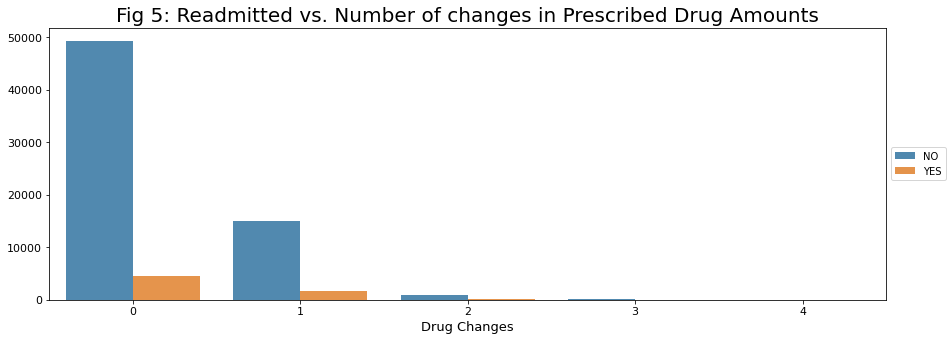

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x=df['drug_changes'], hue=df['readmitted'], alpha=0.85)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig 5: Readmitted vs. Number of changes in Prescribed Drug Amounts', size=20)
ax.set_ylabel('')
ax.set_xlabel('Drug Changes', size=13)
ax.tick_params(axis='both', which='major', labelsize=11);

## ID Features

As seen in the `codes` dataframe, many of values in `admission_source_id`, `admission_type_id`, and `discharge_disposition_id` are very similair (i.e., `discharge_disposition_id` equal to 11, 19, 20 or 21 all indicated the patient expired). 

Similair values are therefore lumped together based on their definition in `codes`. 

In [24]:
for i in tqdm(df.index):
    current_admin_source = df.at[i, 'admission_source_id']
    current_admin_type = df.at[i, 'admission_type_id']
    current_dis = df.at[i, 'discharge_disposition_id']
    
    # admission_source_id
    if current_admin_source in [2, 3]: # lump all referalls
        df.at[i, 'admission_source_id'] = 1 
    
    elif current_admin_source in [5, 6, 10, 18, 19, 22, 25, 26]: # lump all transfers and the one readmission from 
        df.at[i, 'admission_source_id'] = 4                      # the same health agency
        
    elif current_admin_source in [12, 14, 23, 24]: # lump all baby deliveries
        df.at[i, 'admission_source_id'] = 11
        
    elif current_admin_source in [15, 17, 20, 21]: # lump all not available, not mapped, unknown, and NULL
        df.at[i, 'admission_source_id'] = 9 
    
    
    # admission_type_id
    if current_admin_type in [6, 8]: # lump all not available, unknown, NULL
        df.at[i, 'admission_type_id'] = 5
    
    elif current_admin_type in [2, 7]: # lump emergency, urgent care, and trauma center
        df.at[i, 'admission_type_id'] = 1 
    
    
    # discharge_disposition_id
    if current_dis == 5: # lump discharged to home and discharged to home with home health agency
        df.at[i, 'discharge_disposition_id'] = 1 
        
    elif current_dis in [3, 4, 5, 6, 8, 10, 15, 17, 22, 23, 24, 16, 30, 27, 28, 29]: # lump discharged to another facility
        df.at[i, 'discharge_disposition_id'] = 2
        
    elif current_dis in [19, 20, 21]: # lump expired patients
        df.at[i, 'discharge_disposition_id'] = 11 
        
    elif current_dis == 13: # lump both hospice
        df.at[i, 'discharge_disposition_id'] = 14 
        
    elif current_dis in [25, 26]: # lump Null, unknown, etc
        df.at[i, 'discharge_disposition_id'] = 18

100%|██████████| 71518/71518 [00:01<00:00, 43121.94it/s]


After lumping some of these values together, I re-analyze the histograms for these variables. Unfortunately, again, no variable stands out in its potential ability to explain variance in readmission. 

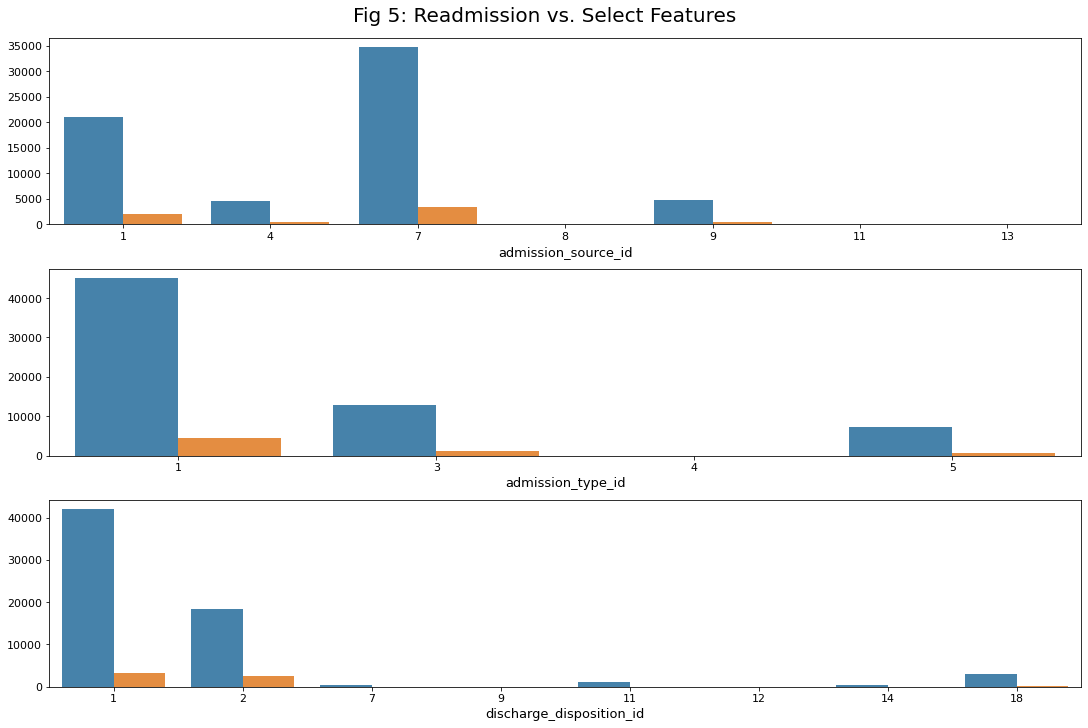

In [25]:
columns = ['admission_source_id', 'admission_type_id', 'discharge_disposition_id']

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])

print_countplots(fig=fig,
                 columns=columns,
                 hue=df['readmitted'])
fig.suptitle("Fig 5: Readmission vs. Select Features", size=20);

In [26]:
def corr_plot(df, title, figsize=(15, 15), max_cols=20):
    """
    Prints correlation plot. If number of columns > max_cols then annotations are turned off. 
    """
  
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=figsize)
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # if too many columns, plot gets messy because of in-box annotations
    if len(df.columns)>max_cols:
        annot = False
    else:
        annot = True   
    
    sns.heatmap(df.corr(),
                annot=annot,
                vmin=-1, vmax=1,
                square=True, 
                cmap=sns.color_palette('RdBu_r', 100),
                mask=mask,
                linewidths=0.5)
    # title
    plt.title(title, size=20)
    
    plt.xticks(size=10)
    plt.yticks(size=10)

## Correlation Matrix

Figure 6 below shows the correlation matrix for a continuous features. Notice that the number of procedures, number of medications, and time in hospital are all positively correlated, as one would expect. 

There is also a slighly positive correlation (0.15) with the number of days the patient was in the hospital the previous year, `number_inpatient`. 

A correlation matrix on the entire one-hot encoded dataset is not shown as it has too meany features and is difficult to ascertain the relationships.

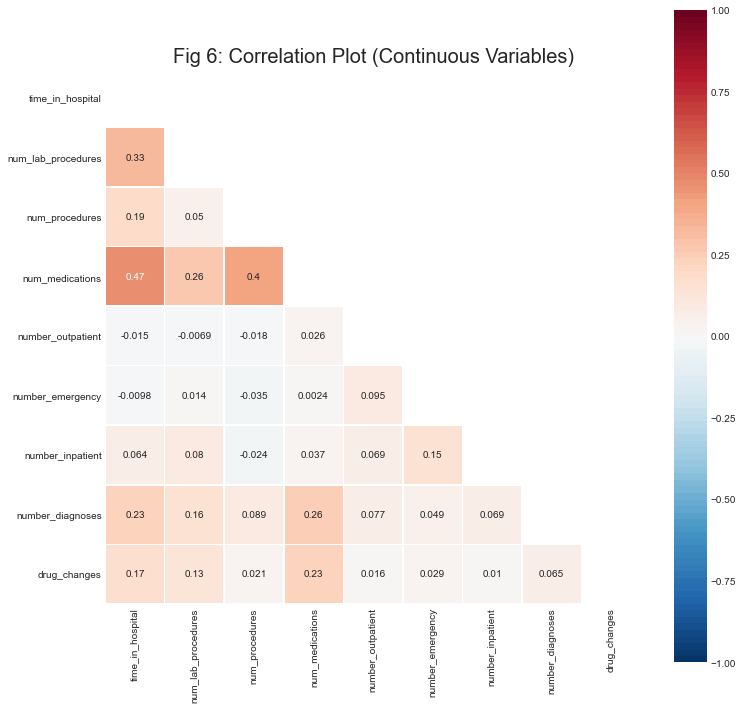

In [27]:
# find categorical and continuous columns
continuous_cols = []
categorical_cols = []
for c in df.columns:
    if df[c].dtype=='int64':
        if 'id' not in c:
            continuous_cols.append(c)
        else:
            categorical_cols.append(c)
    else:
        categorical_cols.append(c)

corr_plot(df[continuous_cols],
          figsize=(12, 12),
          title='Fig 6: Correlation Plot (Continuous Variables)')

# Modelling Prep

## One-Hot Encode Categorical Features

Categorical features are one-hot encoded, resulting in a dataframe with 62 columns.

In [28]:
df_ohe = pd.get_dummies(data=df, columns=categorical_cols, drop_first=True)

In [29]:
df_ohe.shape

(71518, 62)

## Splitting

The dataset is split into `X_train`, `X_test`, `y_train` and `y_test`.  

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_ohe.drop(['readmitted_YES'], axis=1), 
                                                    df_ohe['readmitted_YES'],
                                                    train_size=.8,
                                                    shuffle=True,
                                                    random_state=1)

## Scaling

The training and test data is scaled using `StandardScaler`, which centers the data such that it has $\mu=0$ and $\sigma=1$. Both $\mu$ and $\sigma$ are calculated from the testing data and applied to both the test and training data.  

In [31]:
ct = ColumnTransformer(transformers=[('scaler', StandardScaler(), continuous_cols)],
                       remainder='passthrough')

In [32]:
X_train = pd.DataFrame(ct.fit_transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(ct.transform(X_test),
                      columns=X_test.columns)

# Model Training & Hyperparameter Optimization

Several models are trained using `RandomizedSearchCV` and `GridSearchCV`. I use 5-fold cross validation to select the combination of hyperparameters that maximizes accuracy on the out-of-fold prediction. The following models are used:
- Ridge Regression
- Stochastic Gradient Descent (SGD) Classifier
- Random Forest Classifier
- Adaboost Classifier using Decision Trees with a depth of 1
- Hardvoting Classifier

If a hospital were to use a similair model in a production setting, they may optimize for precision or recall depending on the weight they put on false negatives or positives.

Logistic regression with lasso regularization was also used, but had trouble converging in a reasonable amount of time (<5 minutes). 

In [33]:
metric = 'accuracy'

scores = {} # create empty dict to store models and cross validation best scores

def results(estimator_name, estimator):
    """
    1. Adds fitted model name, fitted model.best_estimator_ and .best_score_ from RandomizedSearchCV to 
    scores, a nested dictionary.
    """
    bp = estimator.best_params_
    eb = estimator.best_estimator_
    es = estimator.best_score_
    
    scores[estimator_name] = {}
    scores[estimator_name][eb] = es
    
    return print(f'Best params: {bp} \n\nBest score: {es}%')

## Logistic Regression with Ridge Regularization

In [34]:
p = {'C':np.arange(1, 16, 1),
     'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':[None, 'balanced']}
ridge = RandomizedSearchCV(LogisticRegression(penalty='l2',
                                              max_iter=2000),
                           param_distributions=p,
                           n_jobs=-1,
                           cv=5,
                           verbose=1,
                           scoring=metric)
ridge.fit(X_train, y_train)
results('ridge', ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


Best params: {'solver': 'sag', 'class_weight': None, 'C': 7} 

Best score: 0.9116999310307461%


## Stochastic Gradient Descent (SGD) Classifier

In [35]:
p = {'alpha':np.linspace(0.000001, 1, 5),
     'penalty':['l1', 'l2'],
     'loss':['hinge', 'log', 'squared_loss', 'huber'],
     'epsilon':np.linspace(0.01, 5, 5)}
sgd = RandomizedSearchCV(SGDClassifier(),
                         param_distributions=p,
                         n_jobs=-1,
                         cv=5, 
                         verbose=1,
                         scoring=metric)
sgd.fit(X_train, y_train)
results('SGD', sgd)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.7s finished


Best params: {'penalty': 'l2', 'loss': 'log', 'epsilon': 5.0, 'alpha': 0.75000025} 

Best score: 0.9117348899540113%


## Random Forest

In [36]:
# random forest
p = {'n_estimators':np.linspace(10, 300, 15).astype(int),
     'bootstrap':[True, False],
     'max_depth':[None, 50, 55, 58, 60, 62, 65, 67, 70, 72, 75],
     'min_samples_split':np.linspace(2, 25, 10).astype(int),
     'min_samples_leaf':np.linspace(2, 100, 10).astype(int),
     'max_features':['auto', 'log2']}

randomforest = RandomizedSearchCV(RandomForestClassifier(),
                                  param_distributions=p,
                                  n_jobs=-1,
                                  cv=5,
                                  verbose=1,
                                  scoring=metric)
randomforest.fit(X_train, y_train)
results('random forest', randomforest)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.9s finished


Best params: {'n_estimators': 92, 'min_samples_split': 9, 'min_samples_leaf': 23, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False} 

Best score: 0.9117348899540113%


## Ensembles

In [37]:
# adaboost with Decision Trees of depth 1
p = {'n_estimators':np.arange(20, 150, 2),
     'learning_rate':np.linspace(0.1, 1, 20)}

adb = RandomizedSearchCV(AdaBoostClassifier(),
                         param_distributions=p,
                         cv=5,
                         verbose=1,
                         n_jobs=-1,
                         scoring=metric)
adb.fit(X_train, y_train)
results('adaboost', adb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.2s finished


Best params: {'n_estimators': 94, 'learning_rate': 0.5736842105263158} 

Best score: 0.9118048001629196%


In [40]:
# hardvoting
model_scores=[]

for c in [randomforest, adb, ridge, sgd]:
    model_scores.append(c.best_score_)
model_scores = ss.rankdata(model_scores).astype(int)

p = {'weights':[None, model_scores]}
hardvoting = GridSearchCV(VotingClassifier(estimators=[('randomforestclf', randomforest.best_estimator_),
                                                       ('adaboostclf', adb.best_estimator_),
                                                       ('ridgeclf', ridge.best_estimator_),
                                                       ('sgdclf', sgd.best_estimator_)],
                                           voting='hard'),
                          param_grid=p,
                          n_jobs=-1,
                          cv=5,
                          verbose=1,
                          scoring=metric)
hardvoting.fit(X_train, y_train)
results('hardvoting', hardvoting)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


Best params: {'weights': array([2, 4, 1, 2])} 

Best score: 0.911787320701287%


## Out of Fold Prediction Performance

The following is the accuracy of the best out of fold prediction for each estimator. As can be seen below, the out of fold prediction accuracy and test set prediction accuracy in the Results section is very close, indicating that the models are not overfitting. 

Overfitting would be unlikely considering cross-validation was used with 5 folds.

In [41]:
print('Cross Validation Results')
for k, v in scores.items():
    for k_, v_ in scores[k].items():
        print(f'{k}: {v_:.8f}%')

Cross Validation Results
ridge: 0.91169993%
SGD: 0.91173489%
random forest: 0.91173489%
adaboost: 0.91180480%
hardvoting: 0.91178732%


# Results

Below is the baseline accuracy - a model outputting all 0's would achieve accuracy of 91.31%. 

Unfortunantly, only the random forest performed better than the baseline, and even that is due to randomness. The models essentially accurately predict almost no variance in readmission.

In [42]:
baseline_accuracy = y_test.value_counts()[0]/(y_test.value_counts()[1] + y_test.value_counts()[0]) * 100
baseline_accuracy

91.3101230425056

In [43]:
for k, v in scores.items():
    for k_, v_ in scores[k].items():
        accuracy = accuracy_score(y_true=y_test,
                                  y_pred=k_.predict(X_test))*100
        report = classification_report(y_true=y_test,
                                       y_pred=k_.predict(X_test),
                                       zero_division=0)
        print(f'Model: {k} \nAccuracy: {accuracy:.8f}% \n{report}')
        if accuracy > baseline_accuracy:
            print(f'Better than baseline.\nAbove baseline: {(accuracy-baseline_accuracy)}.\n\n')
        else:
            print(f'Worse than baseline.\nBelow baseline: {(baseline_accuracy-accuracy)}.\n\n')

Model: ridge 
Accuracy: 91.29614094% 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13061
           1       0.43      0.00      0.01      1243

    accuracy                           0.91     14304
   macro avg       0.67      0.50      0.48     14304
weighted avg       0.87      0.91      0.87     14304

Worse than baseline.
Below baseline: 0.01398210290828672.


Model: SGD 
Accuracy: 91.31012304% 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13061
           1       0.00      0.00      0.00      1243

    accuracy                           0.91     14304
   macro avg       0.46      0.50      0.48     14304
weighted avg       0.83      0.91      0.87     14304

Worse than baseline.
Below baseline: 0.0.


Model: random forest 
Accuracy: 91.31012304% 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13061
           1 

The below ROC scores also paint a grim picture - the dotted line represents a totally random model, and so curves farther away from the model are better. 

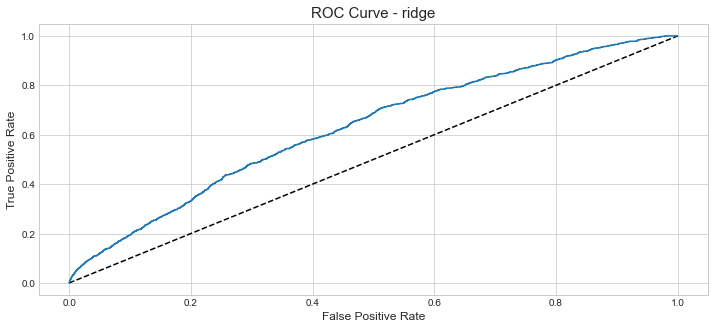

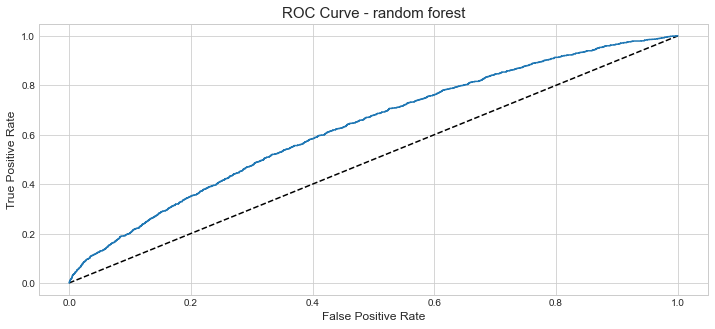

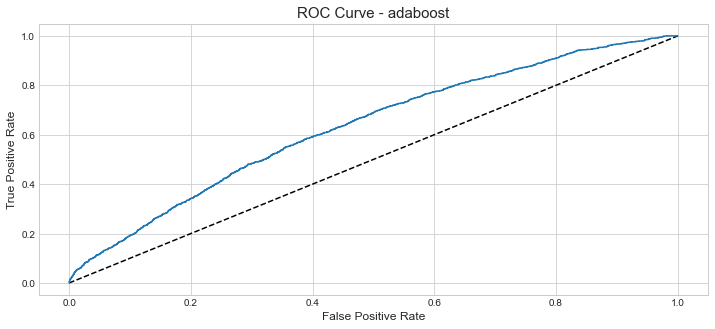

In [44]:
def plot_roc(mod, attribute, X_test=X_test, y_test=y_test):
    """
    Disclaimer: This function is an adaptation from code written by Paul Schrimpf, Thomas Sargent, 
    Quentin Batista, and Natasha Watkins, taken from datascience.quantecon.org. 
    """
    # predicted_probs is an N x 2 array, where N is number of observations
    # and 2 is number of classes
    predicted_probs = mod.predict_proba(X_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate", size=12)
    ax.set_ylabel("True Positive Rate", size=12)
    ax.set_title(f"ROC Curve - {attribute}", size=15)

for k, v in scores.items():
    for k_, v_ in scores[k].items():
        if k=='SGD' or k=='hardvoting': # probability methods not available for loss huber or for hardvoting classifier
            continue
        else:
            plot_roc(mod=k_, attribute=k)

# Conclusion

The models fail to predict hospital readmission when readmission is defined as readmission within 30 days. 


## Further Investigations

There are two areas where further investigation is warranted:
1. Perhaps a neural network can predict readmission using this data.
2. A more thoughtful feature selection, such as Principal Component Analysis (PCA), may lead to improved results. Due to the quantity of features in this dataset, feature selection is extremely important. Through the feature selection above, I may have erroded a large portion of explained variability in this data.
    
    I believe this to be unlikely as there were no features that stood out in figures 3 and 4 - each orange bar is approximately 10% of the adjacent blue bar, which is proportional to the occurence rate of readmission (~8%). Thus, no feature stands out in its ability to explain the variance in readmission. Using PCA, it _may_ be possible to reduce the feature space to a manageable size without erroding too much explaiend variance in readmission. Unfortunantly, I do not think much of the variance in readmission is explained in this dataset (i.e., there are other unknown variables that dramatically impact readmission), and so PCA would likely not be particularly useful. 


### Redefining Readmission
If one changes this definition such that readmission after 30 days also counts as a readmission, then this methodology performs up to 3.4 percentage points better in terms of accuracy using the same approach. To do this, download the notebook and simply change cell 4 such that:
```python
df['readmitted'].replace({'<30':'YES', '>30':'YES'}, inplace=True)
```
and re-run the notebook.

This approach is available [here](https://github.com/alexanderblindsey/hospital_readmissions).